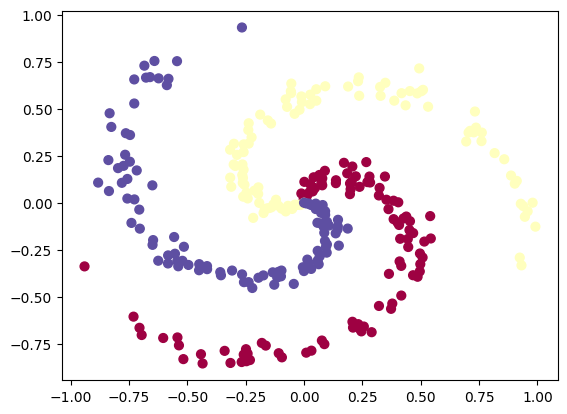

In [397]:
import matplotlib.pyplot as plt
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [398]:
X[:10]

array([[ 0.        ,  0.        ],
       [ 0.00481484,  0.00887963],
       [-0.00141933,  0.0201521 ],
       [ 0.00651079,  0.02959532],
       [ 0.01333203,  0.0381411 ],
       [-0.01147211,  0.04918486],
       [ 0.0233621 ,  0.05592233],
       [ 0.03711016,  0.06018576],
       [ 0.03864951,  0.07096591],
       [ 0.04660548,  0.07805378]])

In [399]:
#2. Turn data into tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [400]:
print(X[:5], y[:5])

tensor([[ 0.0000,  0.0000],
        [ 0.0048,  0.0089],
        [-0.0014,  0.0202],
        [ 0.0065,  0.0296],
        [ 0.0133,  0.0381]]) tensor([0, 0, 0, 0, 0])


In [401]:
#create pandas data frame

import pandas as pd

df = pd.DataFrame(data=X)
df.head()
df["target"] = y
df.head()

,0,1,target
0,0.000000,0.000000,0
1,0.004815,0.008880,0
2,-0.001419,0.020152,0
3,0.006511,0.029595,0
4,0.013332,0.038141,0


In [402]:
df["target"].value_counts()

,count
target,
0,100
1,100
2,100


In [403]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [404]:
len(X_train), len(X_test), len(y_train), len(y_test)

(201, 99, 201, 99)

In [405]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([201, 2]),
 torch.Size([99, 2]),
 torch.Size([201]),
 torch.Size([99]))

In [406]:
# 1. Construct a model class that subclasses nn.Module

from torch import nn

class Multicalassification(torch.nn.Module):
  def __init__(self, input_features, output_features, hidden_units=16):
    super().__init__()

    self.linear = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear(x)

model_0 = Multicalassification(2, 8)
model_0, model_0.state_dict()

(Multicalassification(
   (linear): Sequential(
     (0): Linear(in_features=2, out_features=16, bias=True)
     (1): ReLU()
     (2): Linear(in_features=16, out_features=16, bias=True)
     (3): ReLU()
     (4): Linear(in_features=16, out_features=16, bias=True)
     (5): ReLU()
     (6): Linear(in_features=16, out_features=8, bias=True)
   )
 ),
 OrderedDict([('linear.0.weight',
               tensor([[-0.2871,  0.0188],
                       [-0.1301,  0.5155],
                       [ 0.5543, -0.5697],
                       [-0.2851,  0.5826],
                       [ 0.4845, -0.5096],
                       [-0.3010,  0.5504],
                       [-0.0922, -0.4670],
                       [ 0.6454,  0.5484],
                       [-0.2208,  0.4544],
                       [ 0.3977, -0.6684],
                       [ 0.6096,  0.6059],
                       [-0.6948,  0.3986],
                       [ 0.0398,  0.2851],
                       [ 0.2338, -0.3427],
              

In [407]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [408]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [409]:
epoch_count = []
train_ls = []
test_ls = []

# Set the number of epochs
EPOCHS = 1000

# Build training and evaluation loop
for epoch in range(EPOCHS):

  ### Training
  model_0.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model_0(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  train_loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  ### Testing
  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true=y_test,
                      y_pred=test_pred)


  if epoch % 100 == 0:

    print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}| Acc: {acc} | test_acc: {test_acc}")

    epoch_count.append(epoch)
    train_ls.append(train_loss.detach().numpy())
    test_ls.append(test_loss.detach().numpy())



Epoch: 0 | Train loss: 2.171407461166382 | Test loss: 2.1494688987731934| Acc: 0.0 | test_acc: 0.0
Epoch: 100 | Train loss: 1.001455307006836 | Test loss: 1.0121098756790161| Acc: 60.19900497512438 | test_acc: 58.58585858585859
Epoch: 200 | Train loss: 0.7249293327331543 | Test loss: 0.7359085083007812| Acc: 67.66169154228857 | test_acc: 62.62626262626263
Epoch: 300 | Train loss: 0.6299365162849426 | Test loss: 0.6046856045722961| Acc: 67.66169154228857 | test_acc: 71.71717171717171
Epoch: 400 | Train loss: 0.5196921825408936 | Test loss: 0.47146716713905334| Acc: 76.11940298507463 | test_acc: 84.84848484848484
Epoch: 500 | Train loss: 0.3975233733654022 | Test loss: 0.3516308665275574| Acc: 86.06965174129353 | test_acc: 88.88888888888889
Epoch: 600 | Train loss: 0.2757798135280609 | Test loss: 0.2513028681278229| Acc: 89.55223880597015 | test_acc: 90.9090909090909
Epoch: 700 | Train loss: 0.21109555661678314 | Test loss: 0.1833963841199875| Acc: 93.03482587064677 | test_acc: 92.929292

In [410]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


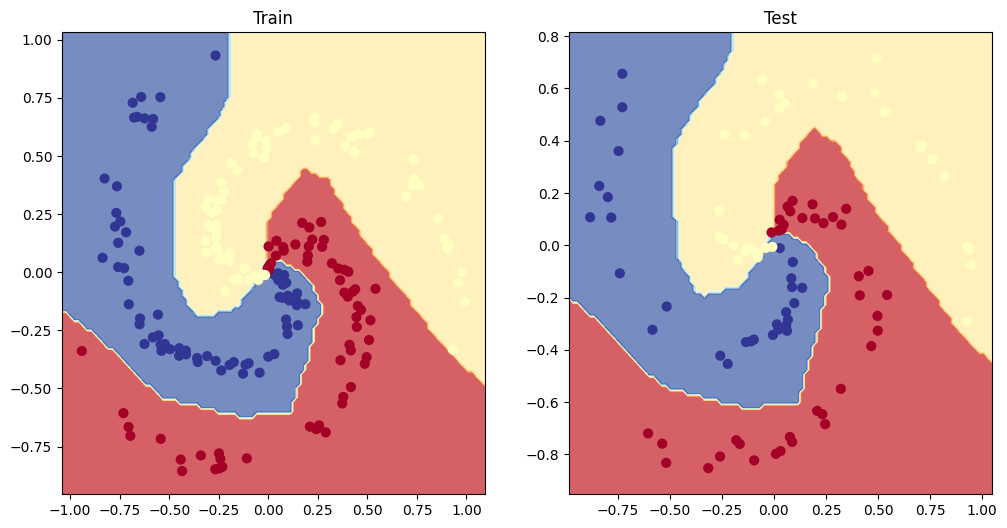

In [411]:
# Plot decision boundaries for training and test sets

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [412]:
train_ls

[array(2.1714075, dtype=float32),
 array(1.0014553, dtype=float32),
 array(0.72492933, dtype=float32),
 array(0.6299365, dtype=float32),
 array(0.5196922, dtype=float32),
 array(0.39752337, dtype=float32),
 array(0.2757798, dtype=float32),
 array(0.21109556, dtype=float32),
 array(0.15288468, dtype=float32),
 array(0.12940654, dtype=float32)]

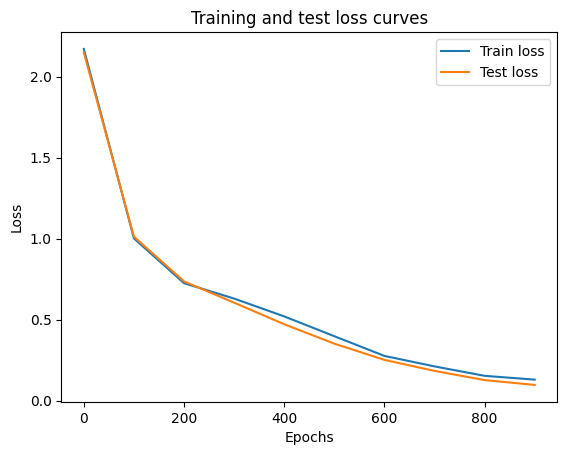

In [413]:
# Plot the loss curves
plt.plot(epoch_count, train_ls, label="Train loss")
plt.plot(epoch_count, test_ls, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();